![Codenation](https://forum.codenation.com.br/uploads/default/original/2X/2/2d2d2a9469f0171e7df2c4ee97f70c555e431e76.png)

__Autor__: Kazuki Yokoyama (kazuki.yokoyama@ufrgs.br)

# Teste de hipótese

Testes de hipótese comuns implementados em python: https://machinelearningmastery.com/statistical-hypothesis-tests/

Existe, por exemplo, teste de hipótese para saber se algoritmos de ML apresentaram resultados diferentes (teste de Friedman).


In [1]:
# um dos exemplos no link
# teste de Friedman
from  scipy.stats  import  friedmanchisquare 


# H0: the distributions of all samples are equal.
# H1: the distributions of one or more samples are not equal.

# dados
data1   =   [ 0.873 ,   2.817 ,   0.121 ,   - 0.945 ,   - 0.055 ,   - 1.436 ,   0.360 ,   - 1.478 ,   - 1.637 ,   - 1.869 ] 
data2   =   [ 1.142 ,   - 0.432 ,   - 0.938 ,   - 0.729 ,   - 0.846 ,   - 0.157 ,   0.500 ,   1.183 ,   - 1.075 ,   - 0.169 ] 
data3   =   [ - 0.208 ,   0.696 ,   0.928 ,   - 1.148 ,   - 0.213 ,   0.229 ,   0.137 ,   0.269 ,   - 0.870 ,   - 1.204 ] 

# teste
stat, p = friedmanchisquare ( data1 ,   data2 ,   data3 ) 
print ( 'stat=%.3f, p=%.3f'   %   ( stat ,   p ) ) 

# verifica a hipótese nula (H0)
if p > 0.05: 
     print( 'Probably the same distribution' ) 
else: 
     print( 'Probably different distributions' ) 

stat=0.800, p=0.670
Probably the same distribution


## Erro associado ao p-valor

Estimaram as taxas de erro associadas a diferentes **p valores**. Embora a taxa de erro exata dependa de várias suposições, a tabela as resume para suposições do meio da estrada.

Prob_erro: Probabilidade de rejeitar incorretamente uma hipótese nula verdadeira

**_p-valor: 0.05_**
* Prob_erro: pelo menos 23% (e geralmente perto de 50%) 
    
**_p-valor: 0.01_**
* Prob_erro: pelo menos 7% (e geralmente perto de 15%) 

# Pensamento estatístico em Python

Neste módulo falaremos sobre testes de hipóteses.

![hypthesis-testing](https://i1.wp.com/statisticsbyjim.com/wp-content/uploads/2018/07/TypesErrorHypothesisTests.png?resize=600%2C400)

In [2]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns

In [3]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize

figsize(12, 8)

sns.set()

## Testes de hipóteses

### Introdução

Já vimos antes como podemos fazer estimativas para parâmetros populacionais a partir de amostras da população. Agora veremos como testar hipóteses sobre parâmetros populacionais, incluindo sua distribuição. Testes de hipóteses são as principais ferramentas da inferência estatística para isso.

Em um teste de hipóteses, formulamos duas hipóteses __complementares__ a respeito de um parâmetro populacional de interesse chamadas hipótese nula (_null hypothesis_) e hipótese alternativa (_alternative hypothesis_). Denotamos a hipótese nula por $H_{0}$ e a hipótese alternativa por $H_{1}$.

__Exemplo__:

Podemos estar interessados na média dos pesos de determinada população ($\mu$) e queremos testar se seu valor verdadeiro é 70 kg a partir de uma amostra coletada. Para isso, geramos as seguintes hipóteses:

$$
\begin{cases}
  H_{0}: \mu = 70 & \quad \text{(Hipótese nula)} \\
  H_{1}: \mu \neq 70 & \quad \text{(Hipótese alternativa)}
\end{cases}
$$

Então seguimos um procedimento para avaliar se devemos:

1. Rejeitar a hipótese nula em favor da hipótese alternativa. Nesse caso, diríamos que a verdadeira média populacional _não_ é 70 kg, mas não conseguiríamos afimar qual é o seu verdadadeiro valor.
2. Não rejeitar a hipótese nula, mantendo-a. Nesse caso, diríamos que não temos evidências o suficiente para rejeitar a hipótese de que a verdadeira média populacional é 70 kg. No entanto, isso não significa que a média deva ser de fato 70 kg, mas sim que a nossa amostra parece sustentar essa ideia.

> Apesar de comum, é incorreto dizer que "aceitamos a hipótese nula". Na verdade, simplesmente __não__ a rejeitamos por falta de evidências.

Algumas observações sobre as hipóteses acima:

* Notem como as duas hipóteses são complementares.
* As hipóteses são feitas sobre o parâmetro populacional ($\mu$) e não sobre o estimador amostral (que poderia ser $\bar{X}$).
* Só existem duas hipóteses. Não podemos gerar múltiplas hipóteses simultaneamente.
* O resultado do teste não nos diz nada sobre nossa teoria, e sim sobre o que os dados indicam.

### Funcionamento

Para seguir com o nosso teste de hipóteses (TH), devemos coletar uma amostra da população e trabalhar com algum estimador do parâmetro populacional sob estudo. No caso acima, podemos utilizar a média amostral ($\bar{X}$) que é o melhor estimador para a média populacional.

Imagine que a média da amostral foi 74 kg. Note como isso pode ocorrer mesmo quando a verdadeira média populacional é 70 kg, pois a amostra é aleatória, e para cada amostra aleatória, obteríamos um valor diferente para a média.

A questão é: essa diferença de 4 kg foi devido ao acaso (devido a aleatoriedade da amostra) ou porque a média populacional não é mesmo 70 kg (talvez 73 kg)? É para responder a esse tipo de questão que usamos o TH.

__Todo procedimento de um TH é feito considerando a $H_{0}$ verdadeira__.

Podemos considerar inicialmente que a verdadeira média populacional é de fato $\mu = 70$ e que os pesos são normalmente distribuídos (depois veremos como relaxar essa suposição).

Sendo isso verdade, as médias de pesos das amostras devem se distribuir normalmente em torno de 70 kg. O que devemos então fazer é definir uma região onde ainda consideramos aceitável presumir que a verdadeira média é 70 kg. Tudo que estiver fora dessa região é considerado "muito longe" para que a verdadeira média seja 70 kg.

A primeira região (a que sustenta a hipótese da média real 70 kg) é chamada __região de aceitação__ (RA), e tudo que estiver fora dela é chamado __região crítica__ (RC).

Por exemplo, podemos definir RA como sendo o intervalo de 68 kg a 72 kg, ou seja, consideramos que qualquer diferença de 2kg ou menos de 70 kg é devido ao acaso. Qualquer valor fora desse intervalo já é longe demais de 70 kg para que esta seja a verdadeira média. Nesse cenário, a nossa média amostral de 74 kg cai na RC e portanto rejeitaríamos a hipótese nula.

O que precisamos agora é de um meio formal de definir essas regiões. Para isso, utilizaremos a informação de que, sob a hipótese nula, a média amostral $\bar{X}$ tem distribuição normal em torno de $\mu = 70$. E em vez de definirmos o tamanho da região de aceitação, definimos o tamanho da região crítica.

Todo TH conta com uma estatística de teste (vamos chamá-la de $T$), que é gerada a partir da amostra. A partir dessa estatística de teste e de sua distribuição, podemos definir RA e RC em termos de probabilidade.

Por exemplo, podemos construir essas regiões de forma que, se $H_{0}$ for verdadeira, então $T$ tem 5% de probabilidade de cair na RC. Essa probabilidade de cair na região crítica, sendo $H_{0}$ verdadeira, é uma probabilidade de erro. Esse erro é chamado de Erro Tipo I e sua probabilidade é chamada __nível de significância__ e denotada por $\alpha$.

Podemos cometer outro tipo de erro ao não rejeitarmos $H_{0}$ quando ela é realmente falsa. Esse é o Erro Tipo II e sua probabilidade é denotada por $\beta$.

Em resumo:

$$\alpha = P(\text{Erro Tipo I}) = P(\text{rejeitar } H_{0} | H_{0} \text{ verdadeira})$$
$$\beta = P(\text{Erro Tipo II}) = P(\text{não rejeitar } H_{0} | H_{0} \text{ falsa})$$

> $\alpha$ e $\beta$ não possuem relação matemática.

__Quando criamos um TH, devemos decidir *a priori* o valor de $\alpha$__. Ele será nossa base de comparação para rejeitarmos ou não a $H_{0}$. Não fazer isso é chamado _p-value hacking_.

Valores típicos de $\alpha$ são 0.025, 0.05 e 0.10.

### Classificação do teste de hipóteses

Os TH podem ser classificados em:

* Bilaterais: quando a região crítica encontra-se dos dois lados da distribuição de $T$ sob $H_{0}$.
* Unilaterais: quando a região crítica encontra-se somente de um dos lados da distribuição de $T$ sob $H_{0}$.

Quando o TH é bilateral, a probabilidade $\alpha$ geralmente é dividida em duas partes iguais, uma em cada lado da distribuição. Quando o TH é unilateral, toda probabilidade acumula-se em um dos lados.

Também podemos falar em hipóteses alternativas simples e compostas:

* Simples: quando não desigualdade.
* Composta: quando há desigualdade.

Na figura a seguir, consideramos que $H_{0}: \mu = \mu_{0}$ e mostramos o caso bilateral e dois unilaterais:

![hypothesis-testing](https://cdn-images-1.medium.com/max/1200/1*-aqjLkyD-mXsA2Hxa8cKSg.jpeg)

### Valor-p

O valor-p (do Inglês, _p-value_), também chamado de _nível descritivo_, de um TH é um valor associado ao resultado, $t^{*}$, da estatística de teste $T$ sob $H_{0}$.

__O valor-p é a probabilidade de $T$ tomar um valor igual ou mais extremo que $t^{*}$, sendo $H_{0}$ verdadeira__.

Obviamente, se essa probabilidade for muito baixa, podemos interpretar que é muito raro encontrarmos $t^{*}$ se $H_{0}$ for realmente verdadeira. Por outro lado, se ela for alta, podemos concluir que deve ser razoável encontrarmos esse valor de $t^{*}$ quando $H_{0}$ é verdadeira.

Mas qual o limiar? O que é considerada uma probabilidade baixa ou alta? É aí que entra o $\alpha$ novamente!

O nosso limiar é o valor de $\alpha$ estabelecido:

* Se o valor-p for menor que $\alpha$, então $t^{*}$ caiu dentro da região crítica, e portanto devemos rejeitar $H_{0}$.
* Se o valor-p for maior que $\alpha$, então $t^{*}$ caiu na região de aceitação e devemos não rejeitar $H_{0}$.

Essa é a importância de estabelecermos $\alpha$ antes do experimento. Do contrário, poderíamos ajustar o valor de $\alpha$ para atender nossas expectativas sobre o resultado.

É importante notar que o valor-p faz sentido no contexto da estatística frequentista, ou seja, considerando a probabilidade no "longo prazo". Além disso, ele nada nos afirma sobre a teoria sendo testada, apenas o que os dados dizem.

Também temos outra interpretação para o valor-p: __O valor-p é o menor nível de significância, $\alpha$, para o qual rejeitaríamos $H_{0}$__.

![p-value](https://i.stack.imgur.com/idDTA.png)

É importante notar que o valor-p é usado extensivamente na estatística frequentista, mas a estatística Bayesiana possui outra abordagem que dispensa o valor-p.

O valor-p é considerado perigoso, pois muitas pessoas não sabem utilizá-lo adequadamente, nem interpretá-lo corretamente, levando a uma série de conclusões duvidosas.

__Lembre-se: o valor-p nos permite fazer afimarções sobre os dados, não sobre a teoria sendo testada__.

Mas como o próprio valor-p se distribui?

De forma geral:

* Quando $H_{0}$ é realmente falsa, a distribuição do valor-p depende do poder do teste, ou seja, da capacidade do teste de detectar uma $H_{0}$ falsa. Quanto maior o poder do teste, maior a chance de obtermos um $\alpha$ pequeno ($< 0.05$).

![1](https://drive.google.com/uc?export=download&id=12Z1cB5T9P2kMp7PXB_xuHitaKwcxbrKF)

* Quando $H_{0}$ é realmente verdadeira, o valor-p tem distribuição uniforme, com $100\alpha\%$ dos valores-p sendo menores que $\alpha$. Em outras palavras, temos $100\alpha\%$ de chance de cometermos um Erro Tipo I.

![2](https://drive.google.com/uc?export=download&id=1PD-1URs2FzaHEF1ZLV2Ajlb0tvY0OXcU)

Vamos fazer simulações de Monte-Carlo para mostrar isso:

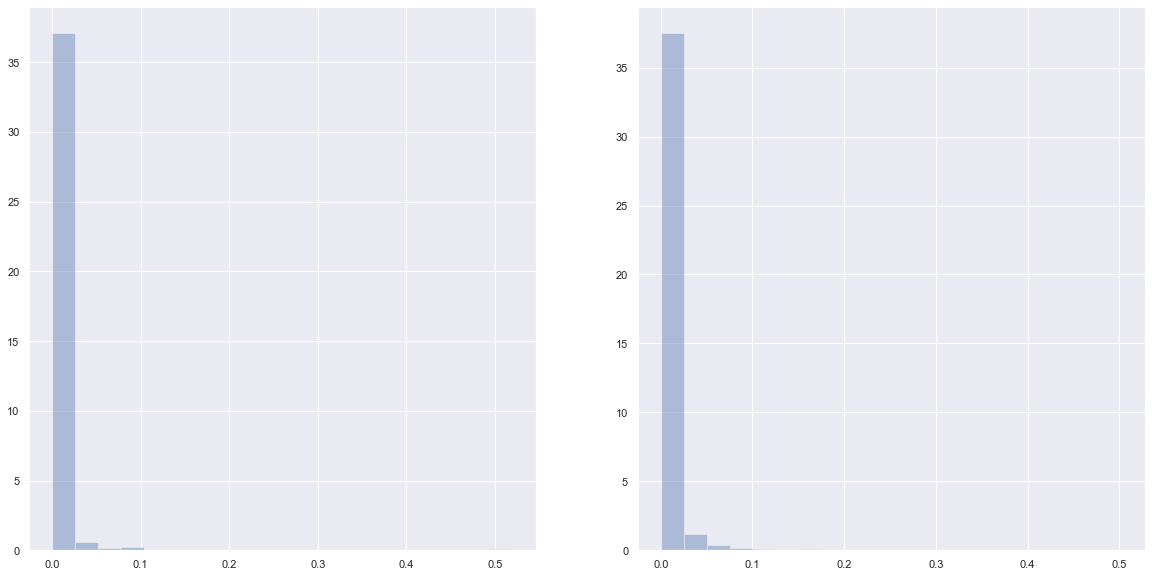

In [4]:
# H_0 é falsa.

pvalues1 = []
for i in range(1000):
    # realiza teste-t (média)
    pvalues1.append(sct.ttest_1samp(sct.norm.rvs(loc=10, scale=5, size=100), popmean=12).pvalue) # Menor poder.

pvalues2 = []
for i in range(1000):
    pvalues2.append(sct.ttest_1samp(sct.norm.rvs(loc=10, scale=5, size=100), popmean=8).pvalue) # Maior poder.

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.distplot(pvalues1, kde=False, bins=20, hist_kws={"density": True}, ax=axs[0])
sns.distplot(pvalues2, kde=False, bins=20, hist_kws={"density": True}, ax=axs[1]);

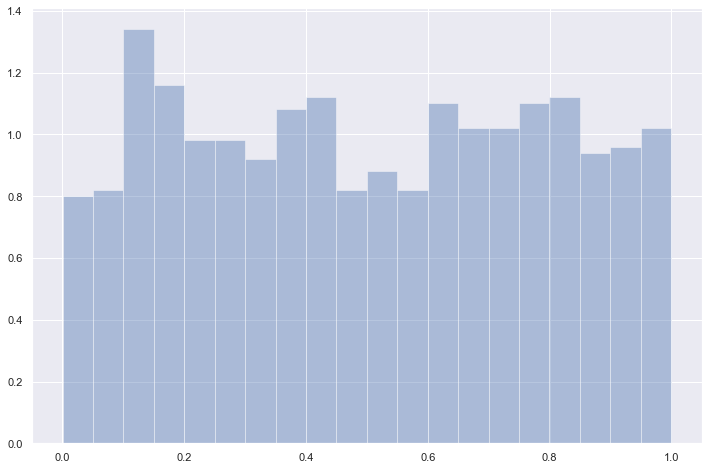

In [5]:
# H_0 é verdadeira.

pvalues = []
for i in range(1000):
    pvalues.append(sct.ttest_1samp(sct.norm.rvs(loc=10, scale=5, size=100), popmean=10).pvalue)


sns.distplot(pvalues, kde=False, bins=20, hist_kws={"density": True});

### Poder

Definimos o poder de um teste como a probabilidade de rejeitarmos $H_{0}$ quando $H_{0}$ é realmente falsa. Em outras palavras, o poder é a probabilidade de não cometermos um Erro Tipo II:

$$\text{Poder} = \pi(\mu) = P(\text{rejeitar } H_{0} | H_{0} \text{ falsa}) = 1 - \beta$$

O poder é bastante influenciado pelo tamanho da amostra, então cuidado com interpretações sobre ele.

## _Q-Q plot_

O _q-q plot_ é um gráfico para comparação de distribuições de probabilidades. Geralmente, uma das distribuições é teórica e com distribuição bem conhecida. Essa distribuição teórica é convencionalmente posta no eixo x. No eixo y, colocamos os quantis da nossa distribuição amostral, que gostaríamos de comparar com a teórica.

![qq-plot](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Normal_normal_qq.svg/686px-Normal_normal_qq.svg.png)

Para o caso mais comum onde em y temos a amostra e em x temos a distribuição teórica com a qual queremos comparar, podemos pensar da seguinte forma:

Sendo a amostra $S = \{s_{1}, s_{2}, \dots, s_{n}\}$, um ponto $(x, y)$ de um _q-q plot_ é tal que:

$$
\begin{cases}
  x = F^{-1}(G(s)) \\
  y = s
\end{cases}
$$

sendo $F^{-1}$ a função quantil (inversa da CDF) da distribuição teórica, $G$ a CDF empírica da amostra e $s = s_{1}, s_{2}, \dots, s_{n}$.

De qualquer forma, a cada ponto $(x_{i}, y_{i})$ do _q-q plot_  vale a relação $F(x_{i}) = G(y_{i})$.

Se as duas distribuições a serem comparadas são de amostras, o raciocínio permanece muito parecido.

Se as duas distribuições forem iguais, ou seja, $F = G$, então os pontos ficarão em cima da reta $y = x$ (inclinada 45º). Quanto mais alinhados os pontos estiverem em cima dessa reta, mais a distribuição da amostra se aproxima da distribuição teórica. Se os pontos ficarem em cima de uma outra reta, mas alinhados, pode ser que as distribuições estejam somente fora de escala. Nesse caso, pode ser interessante transformar uma das distribuições, por exemplo, padronizando a amostra (para ter média 0 e variância 1).

O _q-q plot_ é uma boa forma gráfica de sabermos se as duas distribuições são iguais ou parecidas. A sua intuição é também utilizada em alguns testes de hipóteses para aderência à distribuições teóricas como o teste de normalidade de Jarque-Bera.

__Q-Q plot para dados normais__:

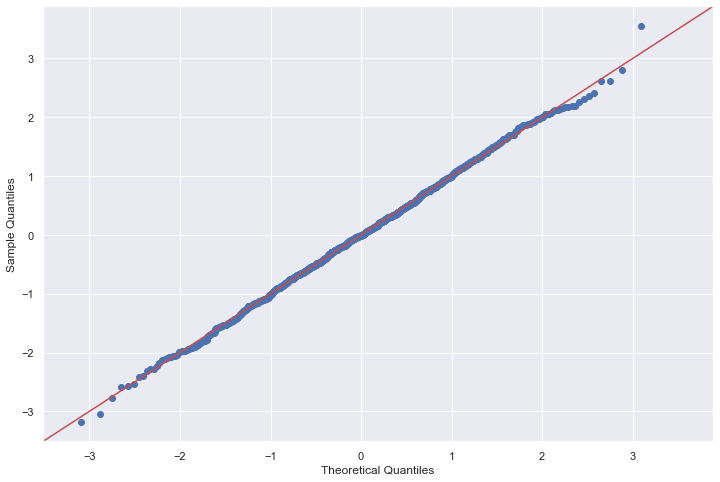

In [6]:
normal_data = sct.norm.rvs(loc=10, scale=4, size=1000)

sm.qqplot(normal_data, fit=True, line="45");

__Q-Q plot para dados não normais__:

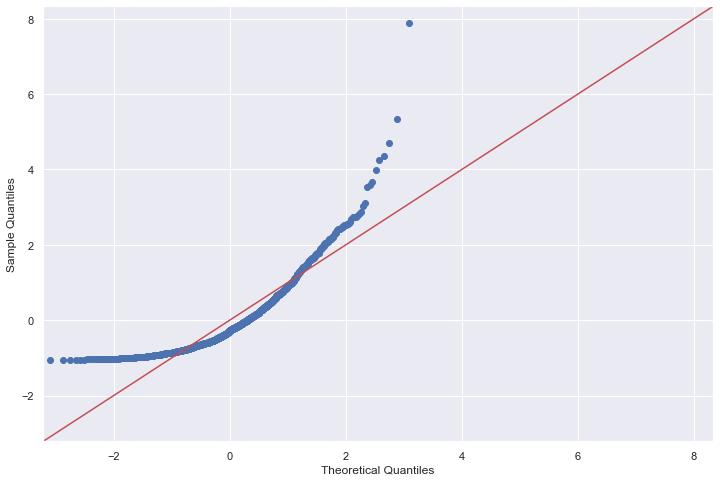

In [7]:
non_normal_data = sct.expon.rvs(size=1000)

sm.qqplot(non_normal_data, fit=True, line="45");

Text(0.5, 1.0, 'Distribuição exponencial vista acima\n')

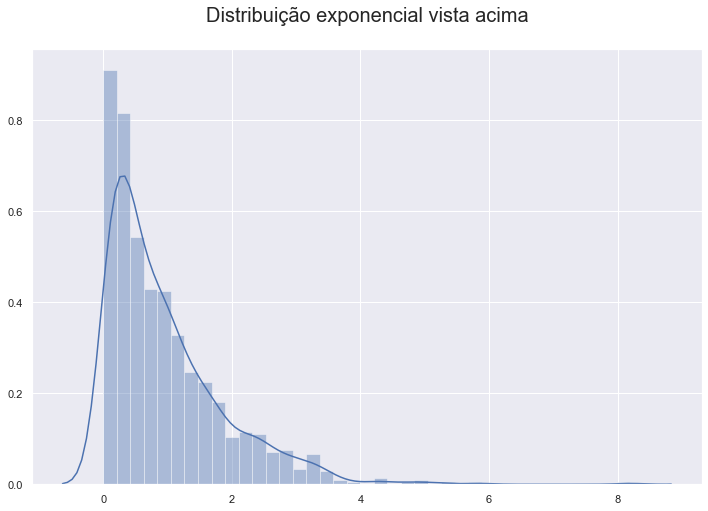

In [8]:
ax = sns.distplot(non_normal_data)
ax.set_title('Distribuição exponencial vista acima\n', fontsize=20)

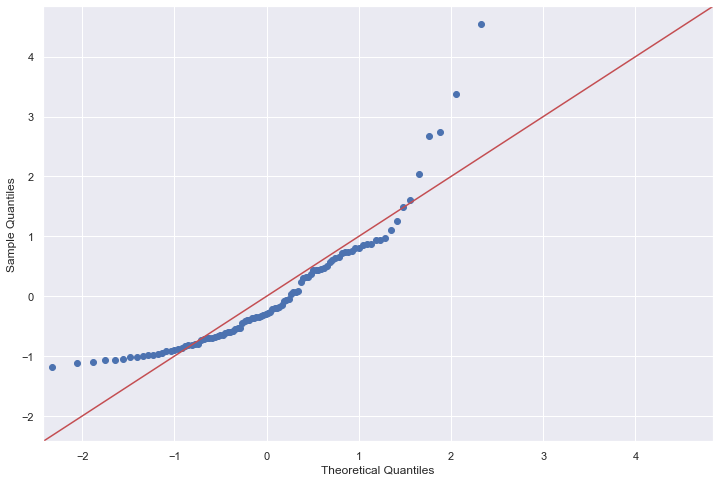

In [29]:
sm.qqplot(normal_data, fit=True, line='45');

In [52]:
def plotaDistribuicaoUniVar(dados):
    # recebe uma coluna de DF e plota distribuição histograma, boxplot e qqplot
    import matplotlib.pyplot as plt
    from seaborn import distplot, boxplot, set
    from statsmodels.api import qqplot 

    %matplotlib inline
    from IPython.core.pylabtools import figsize
    figsize(12, 8)
    #sns.set()
    set()
    
    fig, axs = plt.subplots(2,1)
    # histograma e boxplot
    sns.distplot(dados, bins=25, color='red', ax=axs[0])
    sns.boxplot(dados, color='red', ax=axs[1])

    fig.show()
    
    # grafico de quartis teorico (x) Vs (y) real
    qqplot(dados, fit=True, line='45');

c:\users\jardi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


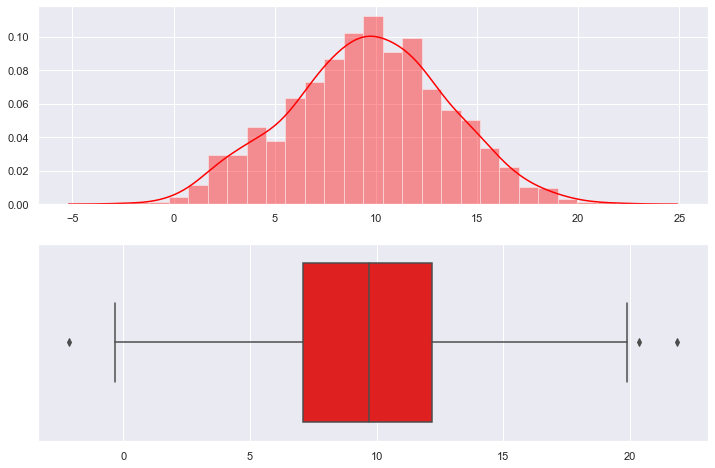

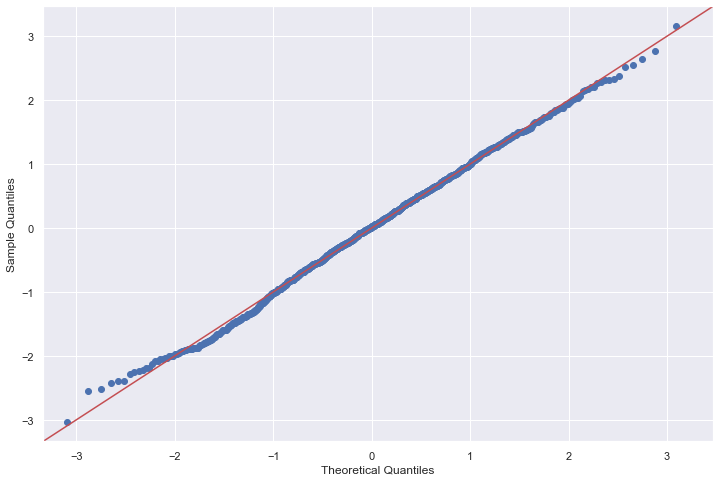

In [53]:
dadoNomal = sct.norm.rvs(loc=10, scale=4, size=1000)
plotaDistribuicaoUniVar(dadoNomal)

c:\users\jardi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


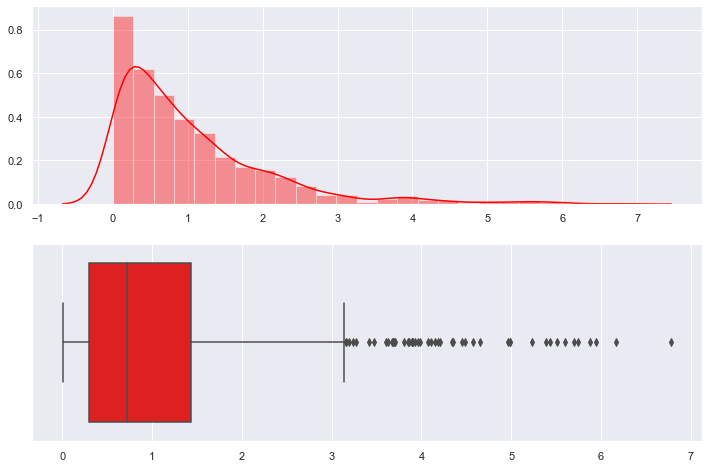

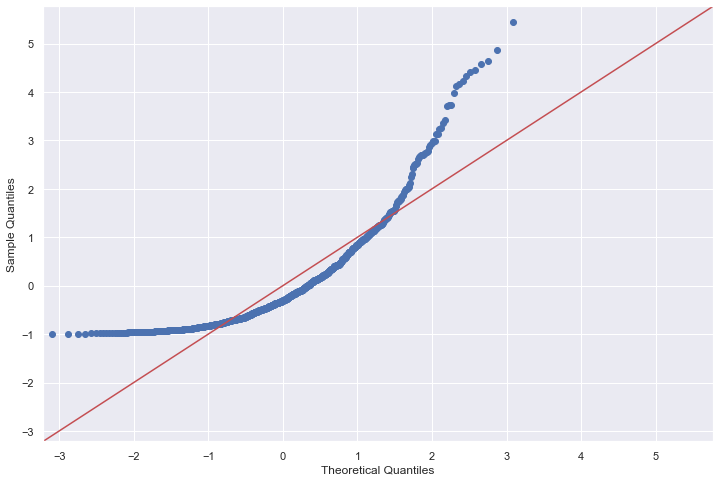

In [49]:
dadoNaoNomal = sct.expon.rvs(size=1000)
plotaDistribuicaoUniVar(dadoNaoNomal)

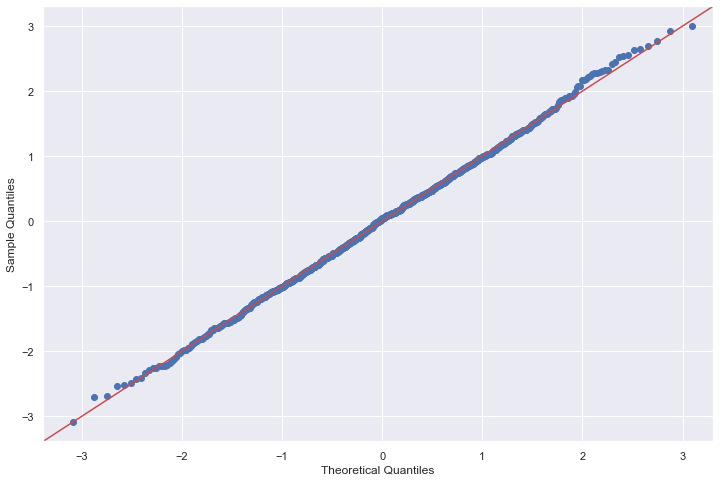

In [39]:
sm.qqplot(dadoNomal, fit=True, line='45');

## Testes de hipóteses clássicos

Diversos testes de hipóteses  para uma gama de tarefas já foram desenvolvidos pela comunidade estatística. Por ora, nosso trabalho é somente entender e saber aplicar os mais usuais. A teoria formal sobre a construção de TH pode ser encontrada facilmente em qualquer literatura sobre inferência estatística.

Dois tipos bem comuns de TH são os testes de comparação e os testes de aderência (_goodness-of-fit_). Veremos aqui dois testes para comparação de médias e dois testes de normalidade: Shapiro-Wilk e Jarque-Bera.

Antes de prosseguirmos, um aviso por Neyman e Pearson:

> _Statistical tests should be used with discretion and understanding, and not as instruments which themeselves give the final verdict_.

### Teste de média de uma amostra

O teste de hipóteses mais conhecido certamente é sobre a média de uma amostra: o famoso teste-$t$ da média.

Nosso objetivo com esse teste é avaliar se uma dada amostra $S$ foi coletada de uma distribuição cuja média $\mu$ é igual a $\mu_{0}$.

Podemos formular nossas hipóteses da seguinte forma:

$$
\begin{cases}
  H_{0}: \mu = \mu_{0} \\
  H_{1}: \mu \neq \mu_{0}
\end{cases}
$$

Partimos de uma suposição inicial: nossa distribuição original é normal sob $H_{0}$ (depois veremos que é possível relaxar isso).

A partir dessa suposição, podemos afimar que nossa média amostral $\bar{X}$ também tem distribuição simétrica de média $\mu_{0}$ e desvio-padrão $s/\sqrt{n}$, chamado erro-padrão.

Para construir nossa estatística de teste $t$, fazemos:

$$t = \frac{\bar{x} - \mu_{0}}{s/\sqrt{n}}$$

onde $\bar{x}$ é a média obtida a partir da amostra, $s$ é o desvio-padrão calculado a partir da amostra e $n$ é o tamanho da amostra.

Essa estatística $t$ tem distribuição $t$-Student com $n-1$ graus de liberdade, que é bem próxima da distribuição normal. Ela é utilizada em vez da normal, pois suas caudas mais pesadas compensam a aproximação feita de $s$ para o desvio padrão.

Como sempre devemos estabelecer _a priori_ o valor de $\alpha$, nosso nível de significância, a fim de compararmos com valor numérico obtido de $t$. Se $t$ cair na região de aceitação (que depende de $\alpha$), então não rejeitamos a hipótese de que a verdadeira média é $\mu_{0}$. Do contrário, podemos dizer que temos evidências o suficiente para rejeitar tal hipótese, e portanto $\mu$ não deve ser igual a $\mu_{0}$.

Para relaxar a suposição de distribuição normal dos dados, apelamos para o Teorema Central do Limite (TCL) que nos afirma que:

$$\bar{X} \xrightarrow{d} N(\mu, \frac{\sigma^{2}}{n})$$

quando $n \rightarrow \infty$.

Ou seja, se tivermos uma amostra grande o suficiente, podemos usar o TCL para justificar os cálculos anteriores, incluindo a fórmula da estatística de teste $t$, sem precisar presumir normalidade dos dados.

Para isso, sob $H_{0}$, substituímos $\mu$ por $\mu_{0}$ e estimamos $\sigma$ como $s$ (desvio-padrão amostral), chegando à mesma fórmula de $t$. Além disso, a distribuição $t$-Student se aproxima de uma distribuição normal quando $n \rightarrow \infty$.

In [9]:
data = sct.expon.rvs(scale=10, size=1000) # Mean = scale = 1/lambda = 10.

sct.ttest_1samp(data, popmean=10) # Deveria não rejeitar H_0.

Ttest_1sampResult(statistic=-0.24710387575566595, pvalue=0.8048786056014763)

In [10]:
data = sct.expon.rvs(scale=8, size=1000) # Mean = scale = 1/lambda = 8.

sct.ttest_1samp(data, popmean=10) # Deveria rejeitar H_0.

Ttest_1sampResult(statistic=-7.559091241740122, pvalue=9.167790018854802e-14)

### Teste de comparação das médias de duas amostras

Outro cenário bastante comum é querermos comparar as médias de duas amostras diferentes para descobrirmos se as duas amostras vêm de distribuições de mesma média.

Entendido o teste anterior, o racional do presente teste é bem direto: usamos a diferença entre as duas médias amostrais e os respectivos desvios-padrão no cálculo da estatística de teste $t$. Ou seja,

$$t = \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{s_{1}^{2} + s_{2}^{2}}}$$

onde $\bar{x}_{1}$ e $\bar{x}_{2}$ são as médias da primeira e segunda amostras e $s_{1}$ e $s_{2}$ são os desvios-padrão das duas amostras.

Sob $H_{0}$, é possível mostrar que $t$ tem distribuição $t$-Student com $n_{1} + n_{2} - 2$ graus de liberdade, onde $n_{1}$ e $n_{2}$ são os tamanhos das amostras.

A interpretação do resultado de $t$ com relação ao nível de significância e consequente rejeição (ou não) de $H_{0}$ é análoga ao teste anterior.

In [11]:
data_one = sct.expon.rvs(scale=8, size=100) # Mesmas distribuições.
data_two = sct.expon.rvs(scale=8, size=100)

sct.ttest_ind(data_one, data_two) # Não deveria rejeitar H_0.

Ttest_indResult(statistic=-0.9364435055075496, pvalue=0.350185655474083)

In [12]:
data_one = sct.expon.rvs(scale=8, size=100) # Distribuições diferentes.
data_two = sct.expon.rvs(scale=12, size=100)

sct.ttest_ind(data_one, data_two) # Deveria rejeitar H_0.

Ttest_indResult(statistic=-2.4078068194290503, pvalue=0.01696587309429244)

### Shapiro-Wilk

O teste de Shapiro-Wilk é um teste de aderência à distribuição normal, que abreviamos para teste de normalidade. Nosso intuito é verificar se uma dada amostra veio ou não de uma distribuição normal.

Não precisamos e não entraremos nos detalhes da sua estatística de teste. Tudo que precisamos saber por ora é:

* A hipótese nula, $H_{0}$, é a normalidade dos dados.

  * Se o valor-p for menor que o nível de significância $\alpha$, então temos evidências de que os dados não vêm de uma distribuição normal.
  * Se o valor-p for maior que $\alpha$, então não podemos afimar que os dados não vêm de uma distribuição normal (o que é sutilmente diferente de afirmar que eles _vêm_ de uma distribuição normal. Cuidado!).
  
* Apesar de ter tendência a melhores resultados quanto maior a amostra, a maior parte das implementações não suporta computações com amostras muito grandes.

  * A implementação do SciPy por exemplo só suporta até 5000 observações.
  
* É altamente aconselhado fazer o teste em conjunto com uma análise gráfica de um _q-q plot_.

In [13]:
normal_data = sct.norm.rvs(loc=10, scale=4, size=100)

sct.shapiro(normal_data)

(0.9881342053413391, 0.5181545615196228)

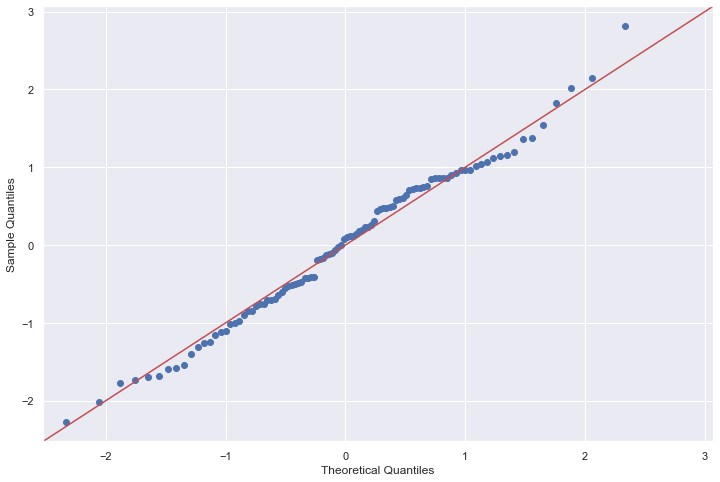

In [14]:
sm.qqplot(normal_data, fit=True, line="45");

In [15]:
normal_data = sct.expon.rvs(scale=4, size=100)

sct.shapiro(normal_data)

(0.8865877389907837, 3.485614570308826e-07)

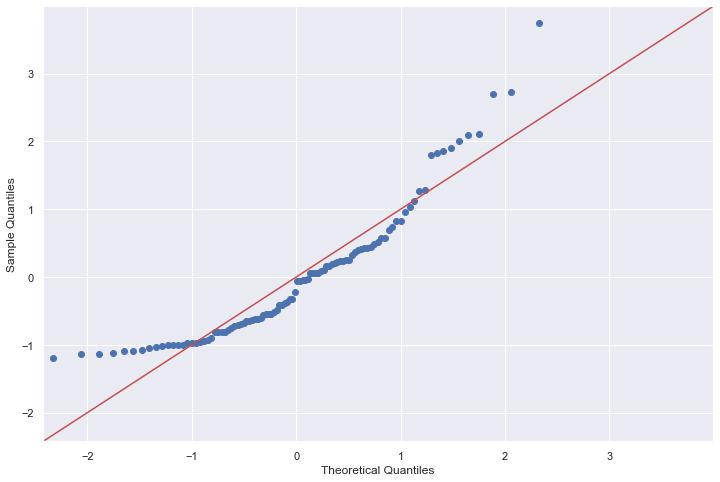

In [16]:
sm.qqplot(normal_data, fit=True, line="45");

### Jarque-Bera

Assim como Shapiro-Wilk, o teste de Jarque-Bera é um teste de aderência à distribuição normal com $H_{0}$ sendo a normalidade dos dados. A diferença reside na estatística de teste utilizada.

A estatística de teste é baseada na assimetria (_skewness_) e curtose (_kurtosis_) excessiva da amostra. Se a amostra vem de uma distribuição normal, então esses valores devem ser muito próximos de zero. Se isso acontecer, então a estatística de teste tem distribuição $\chi^{2}$ com dois graus de liberdade.

No entanto, se a amostra for pequena, podemos ter muitos falsos negativos (Erro Tipo I) ao utilizarmos a distribuição $\chi^{2}$, ou seja, rejeitamos $H_{0}$ quando ela é verdadeira.

Para evitar isso, as implementações costumam utilizar aproximações por Monte-Carlo quando $n$ é pequeno, reservando a aproximação $\chi^{2}$ para amostras grandes.

Novamente, é altamente aconselhado complementar o resultado desse teste com um _q-q plot_.

In [17]:
normal_data = sct.norm.rvs(loc=10, scale=4, size=100)

sct.jarque_bera(normal_data)

(1.0668464130103053, 0.5865934981227032)

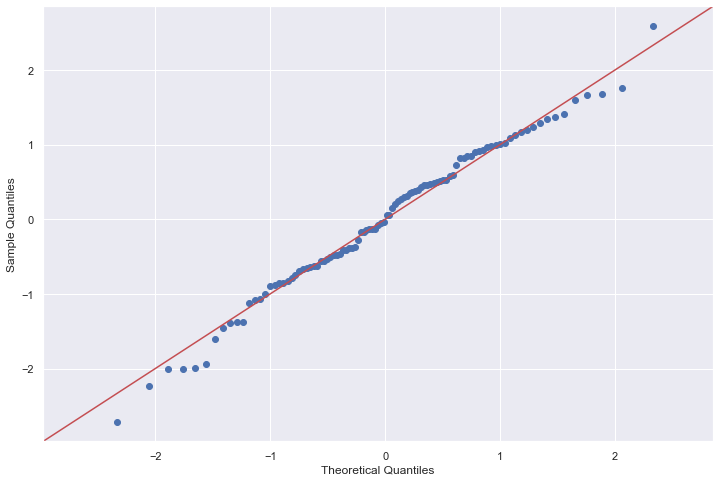

In [18]:
sm.qqplot(normal_data, fit=True, line="45");

In [19]:
normal_data = sct.expon.rvs(scale=4, size=100)

sct.jarque_bera(normal_data)

(127.8736705648492, 0.0)

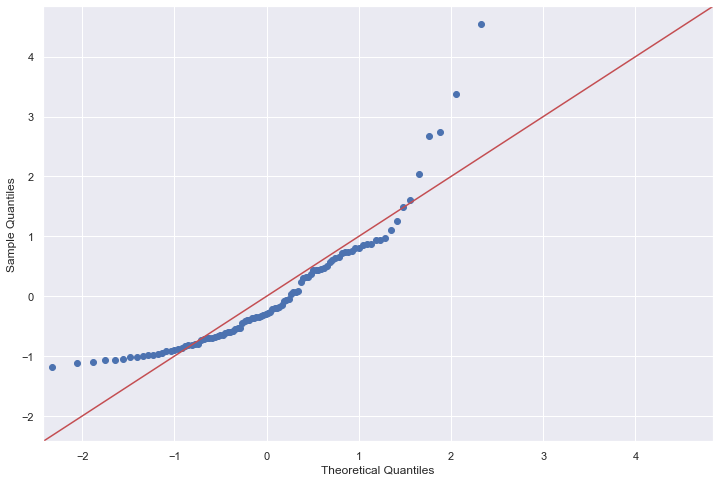

In [20]:
sm.qqplot(normal_data, fit=True, line="45");

## Referências

* [A Gentle Introduction to Statistical Hypothesis Testing](https://machinelearningmastery.com/statistical-hypothesis-tests/)

* [How to Correctly Interpret P Values](https://blog.minitab.com/blog/adventures-in-statistics-2/how-to-correctly-interpret-p-values)

* [A Dirty Dozen: Twelve P-Value Misconceptions](http://www.perfendo.org/docs/BayesProbability/twelvePvaluemisconceptions.pdf)

* [An investigation of the false discovery rate and the misinterpretation of p-values](https://royalsocietypublishing.org/doi/pdf/10.1098/rsos.140216)

* [Statistical tests, P values, confidence intervals, and power: a guide to misinterpretations](https://link.springer.com/content/pdf/10.1007%2Fs10654-016-0149-3.pdf)

* [Why Are P Values Misinterpreted So Frequently?](https://statisticsbyjim.com/hypothesis-testing/p-values-misinterpreted/)

* [Statistical Significance Explained](https://towardsdatascience.com/statistical-significance-hypothesis-testing-the-normal-curve-and-p-values-93274fa32687)

* [Definition of Power](https://newonlinecourses.science.psu.edu/stat414/node/304/)

* [The Math Behind A/B Testing with Example Python Code](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f)

* [Handy Functions for A/B Testing in Python](https://medium.com/@henryfeng/handy-functions-for-a-b-testing-in-python-f6fdff892a90)